In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import ast

import json
import pickle

from Bio import SeqIO, pairwise2

import sys
# if not(base_dir in sys.path): 
#     sys.path.append(base_dir)
#     print("Added " + base_dir + " to path" )


yeast_esr_flag = input("Use yeast_esr_expression functions? (Y/n)")

if yeast_esr_flag =='Y':
    yeast_esr_exp_path = os.path.normpath('C:/Users/heineib/Documents/GitHub/yeast_esr_expression_analysis') + os.sep
    #io_library_path_core = io_library_path + 'core' + os.sep
    if not(yeast_esr_exp_path in sys.path):
        sys.path.append(yeast_esr_exp_path)
        print("Added " + yeast_esr_exp_path + " to path" )

    import yeast_esr_exp
    yeast_esr_exp.base_dir = yeast_esr_exp_path
    yeast_esr_exp.data_processing_dir = yeast_esr_exp_path + os.path.normpath('expression_data') + os.sep


y1000plus_tools_flag = input("Use y1000plus_tools functions? (Y/n)")

if y1000plus_tools_flag =='Y':
    y1000plus_tools_path = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools') + os.sep
    #io_library_path_core = io_library_path + 'core' + os.sep
    if not(y1000plus_tools_path in sys.path):
        sys.path.append(y1000plus_tools_path)
        print("Added " + y1000plus_tools_path + " to path" )

    import y1000plus_tools
    y1000plus_tools.base_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools') + os.sep
    print("y1000plus_tools dir is " + y1000plus_tools.base_dir )                      
    y1000plus_tools.y1000plus_dir = y1000plus_tools.base_dir + 'data' + os.sep 
    print("y1000plus data dir is " + y1000plus_tools.y1000plus_dir)



    
#from venn import venn

y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep
base_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/projects/diverse_yeasts')


#Load y1000 species table
y1000_species = pd.read_csv(y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

#Load S.Cer lookup table: 
scer_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/saccharomyces_cerevisiae.csv')

scer_lookup = pd.read_csv(scer_lookup_fname, index_col=0)
scer_y1000_id_gene_id_lookup = dict(zip(scer_lookup['y1000_id'], scer_lookup.index))

spec_orig_genome_lookup = dict(zip(y1000_species['spec_og_id'], y1000_species['original_genome_id']))

protein_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 


Use yeast_esr_expression functions? (Y/n) Y
Use y1000plus_tools functions? (Y/n) Y


Added C:\Users\heineib\Documents\GitHub\y1000plus_tools\ to path
y1000plus_tools dir is unset
y1000plus data dir is unset
y1000plus_tools dir is C:\Users\heineib\Documents\GitHub\y1000plus_tools\
y1000plus data dir is C:\Users\heineib\Documents\GitHub\y1000plus_tools\data\


In [2]:
sc_annotations_df = pd.read_csv(base_dir + os.sep + 'eggnog_mapper' + os.sep +  'annotation' + os.sep + 'yeastmine_annotation_summary_20211007.csv', index_col = 0)

scer_orf_table = pd.read_table(base_dir + os.sep + 'eggnog_mapper' + os.sep +  'annotation' + os.sep + 'yeastmine_orf_list_20211025.tsv', index_col=1, names= ['SGD_id', 'species', 'Name', 'full_name', 'qualifier', 'status'])

scer_orf_table_not_dub = scer_orf_table[scer_orf_table['qualifier'] != 'Dubious']

sc_annotations_orf = sc_annotations_df.loc[list(set(sc_annotations_df.index) & set(scer_orf_table_not_dub.index ))]

ec_counts = []
for eclist in sc_annotations_orf['EC number']: 
    if type(eclist)==float:
        assert np.isnan(eclist), 'Float but not NaN ' + eclist
        ec_counts.append(0)
    else: 
        eclist_list = ast.literal_eval(eclist)
        ec_counts.append(len(eclist_list))
        

print('{} s. cerevisiae proteins with an EC number'.format(sum(~(sc_annotations_orf['EC number'].isna()))))


## How many have a PDB annotation

print('{} s. cerevisiae proteins with a PDB id'.format(sum(~(sc_annotations_orf['PDB ID'].isna()))))

sc_annotations_ec_subset = sc_annotations_orf[~(sc_annotations_orf['EC number'].isna())]

print('{} s. cerevisiae proteins with and EC number and a PDB id'.format(sum(~(sc_annotations_ec_subset['PDB ID'].isna()))))

## How many have a pathway identified

sc_annotations_orf['N_pathways'] = [len(ast.literal_eval(pway_list)) for pway_list in sc_annotations_orf['Gene.pathways.name']]

sc_annotations_orf[sc_annotations_orf['N_pathways']>0]

# N_pathways_EC = pd.Series([len(ast.literal_eval(pway_list)) for pway_list in sc_annotations_ec_subset['Gene.pathways.name']])

print('{} s. cerevisiae proteins with a Pathway'.format(sum(sc_annotations_orf['N_pathways']>0)))

print('{} s. cerevisiae proteins with and EC number and a Pathway'.format(sum(((sc_annotations_orf['N_pathways']>0) & (~(sc_annotations_orf['EC number'].isna()))))))


sc_annotations_pway_subset = sc_annotations_orf[sc_annotations_orf['N_pathways']>0]



1373 s. cerevisiae proteins with an EC number
1083 s. cerevisiae proteins with a PDB id
299 s. cerevisiae proteins with and EC number and a PDB id
517 s. cerevisiae proteins with a Pathway
469 s. cerevisiae proteins with and EC number and a Pathway


In [3]:
#Proteins missing yeast EC number but which have a curated pathway
sc_annotations_orf[(sc_annotations_orf['N_pathways']>0) & sc_annotations_orf['EC number'].isna()]

#This list makes me think that we want the pathways and not to rely exclusively on EC numbers (since there are some potentially very interesting enzymes in here)

,Gene.symbol,Gene.secondaryIdentifier,Gene.name,Gene.pathways.identifier,Gene.pathways.name,EC number,LoQAtE ID,PANTHER ID,PDB ID,PDB ID Chain,Pathway ID,UniParc ID,UniProtKB ID,N_pathways
YDR297W,SUR2,YDR297W,SUppressor of Rvs161 and rvs167 mutations,['SPHINGOLIPID-SYN-PWY-1'],['sphingolipid biosynthesis (yeast)'],NaN,['4511'],['PTHR11863:SF3'],NaN,NaN,['SPHINGOLIPID-SYN-PWY-1'],['UPI0000136237'],['P38992'],1
YER174C,GRX4,YER174C,GlutaRedoXin,"['GLUT-REDOX2-PWY', 'PWY3O-592']","['glutathione-glutaredoxin redox reactions', '...",NaN,['1819'],['PTHR10293:SF16'],NaN,NaN,"['GLUT-REDOX2-PWY', 'PWY3O-592']",['UPI000013AA60'],['P32642'],2
YKL088W,CAB3,YKL088W,Coenzyme A Biosynthesis,['PANTOSYN2-PWY'],['pantothenate and coenzyme A biosynthesis'],NaN,['985'],['PTHR14359:SF6'],NaN,NaN,['PANTOSYN2-PWY'],['UPI0000052F06'],['P36076'],1
YBR003W,COQ1,YBR003W,COenzyme Q,"['HEXPPSYN-PWY-2', 'PWY3O-862']","['hexaprenyl diphosphate biosynthesis', 'super...",NaN,['1156'],['PTHR12001:SF69'],NaN,NaN,"['HEXPPSYN-PWY', 'HEXPPSYN-PWY-2', 'PWY3O-862']",['UPI0000127EF5'],['P18900'],2
YJL134W,LCB3,YJL134W,Long-Chain Base,['SPHINGOLIPID-SYN-PWY-1'],['sphingolipid biosynthesis (yeast)'],NaN,['2206'],['PTHR14969:SF28'],NaN,NaN,['SPHINGOLIPID-SYN-PWY-1'],['UPI000013B5EF'],['P47013'],1
YGR255C,COQ6,YGR255C,COenzyme Q,"['PWY3O-19', 'PWY3O-862']","['superpathway of ubiquinone biosynthesis', 'u...",NaN,['1161'],['PTHR43876:SF7'],NaN,NaN,"['PWY3O-19', 'PWY3O-862']",['UPI0000127F02'],['P53318'],2
YDR098C,GRX3,YDR098C,GlutaRedoXin,"['GLUT-REDOX2-PWY', 'PWY3O-592']","['glutathione-glutaredoxin redox reactions', '...",NaN,['1818'],['PTHR10293:SF16'],['3D6I'],"['3D6I.A', '3D6I.B']","['GLUT-REDOX2-PWY', 'PWY3O-592']",['UPI0005322FB6'],['Q03835'],2
YKR053C,YSR3,YKR053C,Yeast Sphingolipid Resistance,['SPHINGOLIPID-SYN-PWY-1'],['sphingolipid biosynthesis (yeast)'],NaN,['6659'],['PTHR14969:SF28'],NaN,NaN,['SPHINGOLIPID-SYN-PWY-1'],['UPI000013B650'],['P23501'],1
YHR001W-A,QCR10,YHR001W-A,ubiQuinol-cytochrome C oxidoReductase,['PWY3O-188'],"['aerobic respiration, electron transport chain']",NaN,['3616'],['PTHR28254:SF1'],NaN,NaN,['PWY3O-188'],['UPI000004F920'],['P37299'],1
YKR072C,SIS2,YKR072C,SIt4 Suppressor,['PANTOSYN2-PWY'],['pantothenate and coenzyme A biosynthesis'],NaN,['4223'],['PTHR14359:SF17'],NaN,NaN,['PANTOSYN2-PWY'],['UPI00001359B5'],['P36024'],1


Text(0, 0.5, 'Frequency (Log scale)')

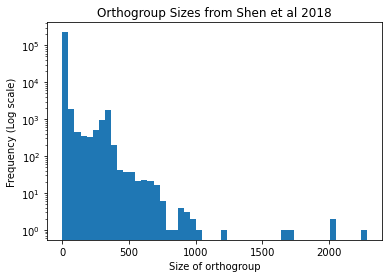

In [25]:
# Summarize size distribution of ortholog mappings: 
orthogroup_fname = y1000plus_dir + os.path.normpath("shen_2018_data/orthomcl_output/orthomcl_clusters.txt")

og_sizes = []

with open(orthogroup_fname, 'r') as f: 
    for line in f: 
        og_genes = line.split()
        og = og_genes[0].strip(':')
        genes = og_genes[1:]
        og_sizes.append(len(genes))
        
fig, ax = plt.subplots(1,1)

ax.hist(og_sizes, log=True, bins = 50)
ax.set_title('Orthogroup Sizes from Shen et al 2018')
ax.set_xlabel('Size of orthogroup')
ax.set_ylabel('Frequency (Log scale)')

In [29]:
# For a given S. cerevisiae protein, provide its og number
# Make mapping of S. cerevisiae proteins to orthogroups

# Species
spec_name = 'Saccharomyces cerevisiae'

#y1000_species = pd.read_csv(y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/y1000_species_table.csv"), index_col=0)

spec_id = y1000_species[y1000_species['Species name']==spec_name]['spec_og_id'].values[0]

spec_og_mapping = {}
with open(orthogroup_fname, 'r') as f: 
    for line in f: 
        og_genes = line.split()
        og = og_genes[0].strip(':')
        genes = og_genes[1:]
        
        gene_ids = [gene_id for gene_id in genes if int(gene_id.split('_')[0])==spec_id]
        
        if len(gene_ids) >= 1:
            for gene_id in gene_ids: 
                spec_og_mapping[gene_id] = og

                
og_set = []

for sc_genename in sc_annotations_pway_subset.index:   #sc_annotations_ec_subset.index: 
    #sc_genename = 'YER144C'
    y1000_id = scer_lookup.loc[sc_genename, 'y1000_id']
    og_in = spec_og_mapping[y1000_id]
    og_set.append(og_in)
    
og_set = list(set(og_set))

print('{} orthogroups contain S. cerevisiae genes with SGD curated pathway'.format(len(og_set)))

445 orthogroups contain S. cerevisiae genes with SGD curated pathway


In [30]:
species_set = pd.read_table(os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/projects/diverse_yeasts/alphafold/species_selection.txt'), index_col = 0)
spec_id_map = {}
for spec_fullname, (exp_flag, clade, load_flag, notes) in species_set[species_set['Load']=='Y'].iterrows():
    y1000_spec_lookup = y1000_species[y1000_species['Species name']==spec_fullname]
    clade_true = y1000_spec_lookup['Major clade'].values[0]
    assert clade_true==clade, 'Clade mismatch: {}, true spelling: {}, bad spelling: {}'.format(spec_fullname, clade_true, clade)
    spec_id = y1000_spec_lookup['spec_og_id'].values[0]
    spec_id_map[spec_id] = spec_fullname
    
spec_ids = set([str(spec_id_int) for spec_id_int in spec_id_map.keys()])

In [7]:

# For a given set of species, and a given orthogroup, extract orthogroup genes

og_out_data = {}  # (N_genes, pct_present, og_genes_out)

for og_in in og_set: 

    with open(orthogroup_fname, 'r') as f: 
        for line in f: 
            og_genes = line.split()
            og = og_genes[0].strip(':')

            if og==og_in: 
                genes = og_genes[1:]
                og_genes_out = []
                for gene in genes: 
                    spec_id = gene.split('_')[0]
                    if spec_id in spec_ids: 
                        og_genes_out.append(gene)

    
    #Calculate the percentage of species contained in the orthogroup.
    og_genes_out_specs = [og_gene.split('_')[0] for og_gene in og_genes_out]
    pct_present = len(set(og_genes_out_specs))/len(spec_ids)

    #Extract Fastas for the orthogroups.  
    
    og_out_data[og_in] = (len(og_genes_out), pct_present, og_genes_out)


# Save og_out_data
og_unfiltered_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes_unfiltered.json'

with open(og_unfiltered_fname, 'w') as f:
    json.dump(og_out_data, f, sort_keys=True, indent=4 )

In [3]:
#Load og_out_data
og_unfiltered_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes_unfiltered.json'
with open(og_unfiltered_fname, 'r') as f:
    og_out_data = json.load(f) 

In [11]:
pct_present_list = []
pct_present_thresh = 0.4
og_out_data_filt = {}
total_genes = 0
for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
    pct_present_list.append(pct_present)
    if pct_present > pct_present_thresh: 
        og_out_data_filt[og] = (N_genes, pct_present, og_genes_out)
        total_genes = total_genes + N_genes
        
print('{} total genes in {} orthogroups'.format(total_genes, len(og_out_data_filt)))

# Save filtered og_out_data

og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes.json'

with open(og_fname, 'w') as f:
    json.dump(og_out_data_filt, f, sort_keys=True, indent=4 )

11569 total genes in 426 orthogroups


In [4]:
#Load og_out_data_filt
og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_genes.json'
with open(og_fname, 'r') as f:
    og_out_data_filt = json.load(f) 

In [75]:
#Make fastas for all proteins without filtering out S. cer and C. albicans using shen genomes.  
fasta_out_fname = base_dir + os.sep + 'alphafold' + os.sep + 'all_proteins.fasta'

source = 'shen_2018'

#lists of gene_full names for each species
gene_full_sets = {}

with open(fasta_out_fname, 'w') as f_out: 

    #for each species: 
    for spec_id, spec_name in spec_id_map.items(): 

        spec = spec_id_map[spec_id]

        spec_orig_genome = spec_orig_genome_lookup[spec_id]
        
        if spec_orig_genome == 'saccharomyces_cerevisiae':
            protein_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Saccharomyces_cerevisiae_S288C_protein.fasta')
        elif spec_orig_genome == 'candida_albicans': 
            protein_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Candida_albicans_SC5314_A22_current_default_protein.fasta')
        else: 
            protein_fname = protein_dir + spec_orig_genome + '.max.pep'
        seq_records = SeqIO.parse(protein_fname, "fasta")
        
        spec_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec_orig_genome + '.csv')

        spec_lookup = pd.read_csv(spec_lookup_fname, index_col=0)
        
        if spec_orig_genome == 'saccharomyces_cerevisiae':
            #for S. cerevisiae the orf name is the 'gene_full'
            gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup.index))
        else: 
            gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup['gene_full']))

        
        
        #for each orthogroup:
        #extract protein seq if it comes from the right species.
        
        #gene_full: (y1000_id, og)
        seqs_to_get = {}
        gene_full_set = []
        for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
            for y1000_id in og_genes_out: 
                spec_id_check = int(y1000_id.split('_')[0])
                if spec_id_check==spec_id:
                    gene_full = gene_full_y1000_id_lookup[y1000_id]
                    seqs_to_get[gene_full] = (y1000_id, og)
                    gene_full_set.append(gene_full)
        
        gene_full_sets[spec_orig_genome] = gene_full_set
        
        for seq_record in seq_records:
            #gene_full = 'augustus_masked-Deha2C-processed-gene-4.36'
            if spec_orig_genome == 'saccharomyces_cerevisiae':
                gene_full_check = seq_record.description.split()[0] #SC specific
            elif spec_orig_genome == 'candida_albicans': 
                gene_full_check = seq_record.description
            else: 
                gene_full_check = seq_record.description.split()[1].split('=')[1]
            #print(gene_full)
            if (gene_full_check in gene_full_set):
                ##find which y1000_id was matched
                #y1000_rlookup = genes_lookup['gene_full'] == gene_full
        #         for gene, tf in y1000_rlookup.items(): 
        #             if tf:
        #                 y1000_id=gene
        #         gene_id = genes_lookup.loc[y1000_id, 'gene_id']
                
                (y1000_id, og) = seqs_to_get[gene_full]
                protein_seq = seq_record.seq
                f_out.write('>' + spec_orig_genome + '__' + og + '__' + y1000_id + ' gene_full=' + gene_full +
                        ' source=' + source + '\n')
                f_out.write(str(protein_seq) + '\n')  #I wonder why some of the bases were in lower case





In [5]:
#Function to parse sequence id from first line of fasta file in either shen or uniprot genomes. 

def gene_id_shen(seq_record):
    gene_id = seq_record.description.split()[1].split('=')[1]
    return gene_id
    
def gene_id_uniprot(seq_record):
    gene_id = seq_record.description.split()[0]
    return gene_id

gene_id_function_dict = {
    "shen": gene_id_shen,
    "uniprot": gene_id_uniprot
}

def gene_id_retrieve(study, seq_record):
    gene_id = gene_id_function_dict[study](seq_record)
    
    return(gene_id)


In [ ]:
#Find matches using genome search

shen_proteome_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 
uniprot_proteome_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/diverse_strains/proteomes') + os.sep 

#(species genome name: (shen_fname, uniprot_fname)): 
proteome_fasta_dict = {'kluyveromyces_lactis': {'shen': shen_proteome_dir + 'kluyveromyces_lactis.max.pep', 
                                                'uniprot': uniprot_proteome_dir + 'Klac_uniprot-proteome_UP000000598.fasta'
                                               }, 
                       'wickerhamomyces_anomalus': {'shen': shen_proteome_dir + 'wickerhamomyces_anomalus.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Wano_uniprot-proteome_UP000094112.fasta'
                           }, 
                       'lachancea_thermotolerans': {'shen': shen_proteome_dir + 'lachancea_thermotolerans.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Lthe_uniprot-proteome_UP000002036.fasta'
                           }, 
                       'komagataella_pastoris': {'shen': shen_proteome_dir + 'komagataella_pastoris.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Kpas_uniprot-proteome_UP000000314.fasta'
                           }, 
                        'candida_tropicalis': {'shen': shen_proteome_dir + 'candida_tropicalis.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Ctro_uniprot-proteome_UP000002037.fasta'
                           },
                        'debaryomyces_hansenii': {'shen': shen_proteome_dir + 'debaryomyces_hansenii.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Dhan_uniprot-proteome_UP000000599.fasta'
                           }, 
                        'yHMPu5000034957_hanseniaspora_osmophila_160519': {'shen': shen_proteome_dir + 'yHMPu5000034957_hanseniaspora_osmophila_160519.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Hosm_uniprot-proteome_UP000095728.fasta'
                           }, 
                        'kluyveromyces_marxianus': {'shen': shen_proteome_dir + 'kluyveromyces_marxianus.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Kmar_uniprot-proteome_UP000065495.fasta'
                           }, 
                        'zygosaccharomyces_rouxii': {'shen': shen_proteome_dir + 'zygosaccharomyces_rouxii.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Zrou_uniprot-proteome_UP000008536.fasta'
                           }
                      }

study1 = 'shen'
study2 = 'uniprot'

match_points = 1
mismatch_points = -1
gap_open = -.5
gap_extension = -0.1
NN_top_scores = 5
penalize_end_gaps = True 


#pairwise_scores = {}
spec_orig_genomes = [ 'yHMPu5000034957_hanseniaspora_osmophila_160519']  #'zygosaccharomyces_rouxii','kluyveromyces_marxianus','candida_tropicalis', 'debaryomyces_hansenii',

for spec_orig_genome in spec_orig_genomes:
    print(spec_orig_genome)
    #spec_orig_genome = 'komagataella_pastoris'# 'lachancea_thermotolerans' #'wickerhamomyces_anomalus' # 'kluyveromyces_lactis'

    use_subset = True
    subset = set(gene_full_sets[spec_orig_genome])
    pairwise_score_loaded = False #if you have already saved some and want to do the rest

    # #Check timing with time module
    # #python parallel programming library
    # #ipy_parallel dask
    # #https://ipyparallel.readthedocs.io/en/stable/development/messages.html#parallel-messages

    # #All by all pairwise sequence alignment, output top NN results

    genenames_study1 = []
    AA_seqs_study1 = SeqIO.parse(proteome_fasta_dict[spec_orig_genome][study1], "fasta")
    for seq_study1 in AA_seqs_study1: 
        genename_study1 = gene_id_retrieve(study1, seq_study1)
    #     if spec=='Smik': 
    #         genename_study1_dash = genename_study1
    #         genename_study1 = 'smik' + genename_study1_dash.split('smik_')[1]
        genenames_study1.append(genename_study1)

    if use_subset: 
        print('Using Subset genes')
    else: 
        subset = set(genenames_study1)

    if pairwise_score_loaded: 
        genes_to_search = ((subset & set(genenames_study1)) - set(pairwise_score.keys()))
    else: 
        pairwise_score = {}
        genes_to_search = (subset & set(genenames_study1))


    AA_seqs_study1 = SeqIO.parse(proteome_fasta_dict[spec_orig_genome][study1], "fasta")


    N = len(genes_to_search)
    for seq_study1 in AA_seqs_study1: 
        check_gene = False
        genename_study1 = gene_id_retrieve(study1, seq_study1)
    #     if spec=='Smik': 
    #         genename_study1_dash = genename_study1
    #         genename_study1 = 'smik' + genename_study1_dash.split('smik_')[1]
        if genename_study1 in genes_to_search:
            check_gene = True

        if check_gene: 
            print(str(N) + ' ' + genename_study1)
            AA_seqs_study2 = SeqIO.parse(proteome_fasta_dict[spec_orig_genome][study2], "fasta")
            pairwise_score_comps = {}
            for seq_study2 in AA_seqs_study2: 
                genename_study2 = seq_study2.id
                score = pairwise2.align.globalms(seq_study2,seq_study1, match_points, mismatch_points, gap_open, gap_extension, penalize_end_gaps = penalize_end_gaps, score_only = True )
                pairwise_score_comps[genename_study2] = score
            pairwise_score_comps_df = pd.Series(pairwise_score_comps)
            pairwise_score[genename_study1] = pairwise_score_comps_df.sort_values(ascending=False).iloc[0:NN_top_scores]
            #print(pairwise_score[genename_YGOB])
            N = N - 1

    pairwise_scores[spec_orig_genome] =  pairwise_score

In [6]:
pairwise_scores_fname = base_dir + os.sep + 'alphafold' + os.sep + 'pairwise_scores.pkl'

# # Save pairwise_scores
# with open(pairwise_scores_fname, 'wb') as f:
#     pickle.dump(pairwise_scores, f)

# Load pairwise_scores
with open(pairwise_scores_fname, 'rb') as f: 
    pairwise_scores = pickle.load(f)

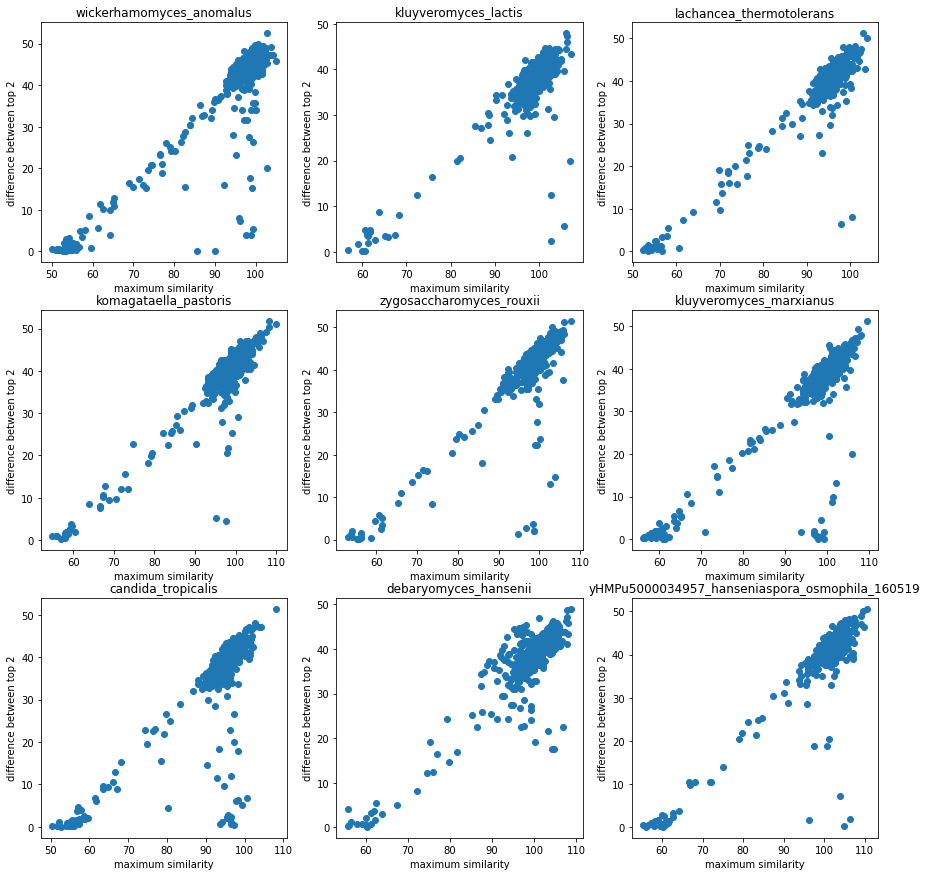

In [7]:
## Show histogram of the pairwise scores and use it to choose thresholds: 

fig, axarr = plt.subplots(3,3, figsize=(15,15))

#pairwise_scores = {}
#for jj, spec in enumerate(['Ncas','Klac','Smik']):

#pairwise_score_fname = data_processing_dir + os.path.normpath("ortholog_files_YGOB/AA_lists/" + spec + "_pairwise_score.pkl")

#with open(pairwise_score_fname,'rb') as file: 
#    pairwise_score= pickle.load(file)

#pairwise_scores[spec] = pairwise_score
#Use histogram to choose thresholds

for jj, (spec_orig_genome, pairwise_score) in enumerate(pairwise_scores.items()):
    ax = axarr.flatten()[jj]
    maxvals = []
    diff_top2 = []
    for genename_shen, options in pairwise_score.items(): 
        options_sorted = options.sort_values()
        #idxmax = options.idxmax()
        maxval = options_sorted[-1]
        diff_top2_val = maxval-options_sorted[-2]
        diff_top2.append(diff_top2_val)
        maxvals.append(maxval)
        #if maxval<90: 
        #if (maxval>90) & (diff_top2_val<20):
        #   print('{}, maxval: {}, difference: {}'.format(genename_shen,maxval,diff_top2_val))

    
    ax.scatter(maxvals, diff_top2)
    ax.set_title(spec_orig_genome)
    ax.set_xlabel('maximum similarity')
    ax.set_ylabel('difference between top 2')
    #ax.set_title(spec)

In [ ]:
# if genome_name == 'saccharomyces_cerevisiae':
#     #load gene_id map based on the species
#     gene_lookup_spec_fname = y1000plus_dir + os.path.normpath("y1000plus_tools_data/y1000plus/id_lookups/" + genome_name + '.csv')
#     gene_lookup_spec = pd.read_csv(gene_lookup_spec_fname, index_col='y1000_id')

#     protein_fname = y1000plus_dir + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/Saccharomyces_cerevisiae_S288C_protein.fasta')

#     seq_records = SeqIO.parse(protein_fname, "fasta")

#     genes_lookup = gene_lookup_spec.loc[genes]
#     genes_lookup_set = set(gene_lookup_spec.loc[genes,'gene_id'].values)  #SC specific

#     for seq_record in seq_records:
#         gene_id = seq_record.description.split()[0] #SC specific
#         #print(gene_full)
#         if (gene_id in genes_lookup_set):
#             #find which y1000_id was matched
#             y1000_rlookup = (genes_lookup['gene_id'] == gene_id)
#             for gene, tf in y1000_rlookup.items(): 
#                 if tf:
#                     y1000_id=gene
#             protein_seq = seq_record.seq
#             f.write('>' + genome_name + '_' + gene_id + ' y1000_id=' + y1000_id + ' gene_id=' + gene_id +
#                     ' common_name=' + seq_record.description.split()[1] + #this adds in the cds from the original description
#                     '\n')
#             f.write(str(protein_seq) + '\n')  #I wonder why some of the bases were in lower case

In [5]:
# Get Orthogroup metadata
#Cycle through each protein. 

#Record Metadata

#OG Metadata: 
# SC Genenames, SP genenames, CA genenames
# Total number
# Percent of species covered
#Possible future
# Pathways
# Enzyme numbers

#{og: N_genes, pct_spec, og_genes, pathways, enzyme_numbers, sc_genenames, sc_names, sp_genename, ca_genename}

scer_spec_id = 110

#Build lookup table from S. pombe to S. cerevisiae
sp_orth_map_fname = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/spom/cerevisiae-orthologs.txt')
sp_orth_map = pd.read_table(sp_orth_map_fname, skiprows=1, header=None, names=['Spom','Scer'])
scer_spom_lookup = {}
none_list = []
for row, (spom_gene, scer_genes) in sp_orth_map.iterrows():
    if scer_genes=='NONE': 
        none_list.append(spom_gene)
    else:
        scer_genes_list = scer_genes.split('|')
        for scer_gene in scer_genes_list: 
            scer_spom_lookup[scer_gene] = spom_gene

#build C. albicans lookup table 
ca_orth_map_fname = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/calb/C_albicans_SC5314_S_cerevisiae_orthologs.txt')
ca_orth_map = pd.read_table(ca_orth_map_fname, skiprows=8, header=None, names = ['cg_name', 'cgd_id', 'sc_genename', 'sc_name', 'sgd_id']) #, names=['Spom','Scer'])
scer_calb_lookup = dict(zip(ca_orth_map['sc_genename'], ca_orth_map.index))

            
            
og_out_data_full = {}
jj = 0
for (og, (N_genes, pct_spec, og_genes)) in og_out_data.items():
    #print(og + ' ' + str(jj))
    og_out_data_full_item = {}
    og_out_data_full_item['N_genes'] = N_genes
    og_out_data_full_item['pct_spec'] = pct_spec
    og_out_data_full_item['og_genes'] = og_genes
        
    #get_sc_genes
    sc_genes = []
    for og_gene in og_genes: 
        spec_id_check = int(og_gene.split('_')[0])
        if spec_id_check==scer_spec_id:
            sc_genes.append(scer_y1000_id_gene_id_lookup[og_gene])
    
    #get pathway and EC annotations
    og_out_data_full_item['sc_genes'] = sc_genes
    og_out_data_full_item['sc_names'] = yeast_esr_exp.SC_common_name_lookup(sc_genes)
    og_out_data_full_item['pathways_id'] = list(sc_annotations_orf.loc[sc_genes]['Gene.pathways.identifier'])
    og_out_data_full_item['pathways_name'] = list(sc_annotations_orf.loc[sc_genes]['Gene.pathways.name'])
    og_out_data_full_item['EC_number'] = list(sc_annotations_orf.loc[sc_genes]['EC number'])
    og_out_data_full_item['PDB_ID'] = list(sc_annotations_orf.loc[sc_genes]['PDB ID'])
    
    #get sp_genes
    sp_genes = []
    ca_genes = []
    for sc_gene in sc_genes: 
        if sc_gene in scer_spom_lookup.keys(): 
            sp_genes.append(scer_spom_lookup[sc_gene])
        else: 
            sp_genes.append('NONE')
        
        if sc_gene in scer_calb_lookup.keys(): 
            ca_genes.append(scer_calb_lookup[sc_gene])
        else: 
            ca_genes.append('NONE')
    
    og_out_data_full_item['spom_genes'] = sp_genes
    og_out_data_full_item['calb_genes'] = ca_genes
    
    
    og_out_data_full[og] = og_out_data_full_item
    jj = jj + 1




NameError: name 'og_out_data' is not defined

In [246]:
# Save og_out_data_full (or metadata file)
og_out_data_full_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json'

with open(og_out_data_full_fname, 'w') as f:
    json.dump(og_out_data_full, f, indent=4 )

In [8]:
#Load og_out_data_filt
og_fname = base_dir + os.sep + 'alphafold' + os.sep + 'og_metadata.json'
with open(og_fname, 'r') as f:
    og_out_data_full = json.load(f) 

In [13]:
genename_full_uniprot = pairwise_scores['wickerhamomyces_anomalus']['snap_masked-scaffold_1-processed-gene-0.81']

In [19]:
a = genename_full_uniprot.sort_values(ascending=False)

In [22]:
a.index[0]

'tr|A0A1E3P7Y6|A0A1E3P7Y6_WICAA'

In [ ]:
for jj, (spec_orig_genome, pairwise_score) in enumerate(pairwise_scores.items()):
    ax = axarr.flatten()[jj]
    maxvals = []
    diff_top2 = []
    for genename_shen, options in pairwise_score.items(): 
        options_sorted = options.sort_values()
        #idxmax = options.idxmax()
        maxval = options_sorted[-1]
        diff_top2_val = maxval-options_sorted[-2]
        diff_top2.append(diff_top2_val)
        maxvals.append(maxval)
        #if maxval<90: 
        #if (maxval>90) & (diff_top2_val<20):
        #   print('{}, maxval: {}, difference: {}'.format(genename_shen,maxval,diff_top2_val))

In [ ]:
#gene_full_set_shen: (y1000_id, og)

In [60]:
#Build Fasta file

fasta_out_fname = base_dir + os.sep + 'alphafold' + os.sep + 'selected_proteins.fasta'

#the following information is in the fasta header for each protein
#<spec_orig_genome>__<og>__<y1000_id>: you can use this to look up other metadata in the og_metadata.json file
#source:  The source of the peptide sequence (either 'shen' or 'uniprot')
#gene_full:  The full name of the gene from source peptide file
#gene_full_shen: the full name of the gene from the shen peptide file
#L: Length of the gene
#sim_score_vs_shen: The similarity score between the shen peptide sequence and the uniprot peptide sequence.  If it is above the threshold, the uniprot sequence is used, below the threshold, we continue to use the shen sequence
#sim_score_vs_shen_diff: The difference between similarity score of the top peptide and the second highest scoring peptide.  For genes with similarity score below a threshold, if this difference is too small, we keep the shen sequence

shen_proteome_dir = os.path.normpath(y1000plus_dir + 'shen_2018_data/0_332yeast_genomes/332_genome_annotations/pep') + os.sep 
uniprot_proteome_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/external_data/genomes/diverse_strains/proteomes') + os.sep 

#(species genome name: (shen_fname, uniprot_fname)): 
proteome_fasta_dict = {'kluyveromyces_lactis': {'shen': shen_proteome_dir + 'kluyveromyces_lactis.max.pep', 
                                                'uniprot': uniprot_proteome_dir + 'Klac_uniprot-proteome_UP000000598.fasta'
                                               }, 
                       'wickerhamomyces_anomalus': {'shen': shen_proteome_dir + 'wickerhamomyces_anomalus.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Wano_uniprot-proteome_UP000094112.fasta'
                           }, 
                       'lachancea_thermotolerans': {'shen': shen_proteome_dir + 'lachancea_thermotolerans.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Lthe_uniprot-proteome_UP000002036.fasta'
                           }, 
                       'komagataella_pastoris': {'shen': shen_proteome_dir + 'komagataella_pastoris.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Kpas_uniprot-proteome_UP000000314.fasta'
                           }, 
                        'candida_tropicalis': {'shen': shen_proteome_dir + 'candida_tropicalis.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Ctro_uniprot-proteome_UP000002037.fasta'
                           },
                        'debaryomyces_hansenii': {'shen': shen_proteome_dir + 'debaryomyces_hansenii.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Dhan_uniprot-proteome_UP000000599.fasta'
                           }, 
                        'yHMPu5000034957_hanseniaspora_osmophila_160519': {'shen': shen_proteome_dir + 'yHMPu5000034957_hanseniaspora_osmophila_160519.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Hosm_uniprot-proteome_UP000095728.fasta'
                           }, 
                        'kluyveromyces_marxianus': {'shen': shen_proteome_dir + 'kluyveromyces_marxianus.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Kmar_uniprot-proteome_UP000065495.fasta'
                           }, 
                        'zygosaccharomyces_rouxii': {'shen': shen_proteome_dir + 'zygosaccharomyces_rouxii.max.pep',
                            'uniprot': uniprot_proteome_dir + 'Zrou_uniprot-proteome_UP000008536.fasta'
                           }
                      }


sim_score_high_thresh = 75
sim_score_low_thresh = 60
sim_score_diff_thresh = 8


with open(fasta_out_fname, 'w') as f_out: 

    #for each species: 
    for spec_id, spec_name in spec_id_map.items(): 
        spec = spec_id_map[spec_id]

        spec_orig_genome = spec_orig_genome_lookup[spec_id]
        print(spec_orig_genome)
        
        if spec_orig_genome in {'saccharomyces_cerevisiae', 'candida_albicans'}: 
            print('skipping ' + spec_orig_genome)
            #Skip this species
        elif spec_orig_genome in proteome_fasta_dict.keys():
            #Attempt to convert to uniprot fasta  
            print('checking to see if uniprot or shen et al sequences should be used')
            source = 'uniprot'
            
            protein_fname_uniprot = proteome_fasta_dict[spec_orig_genome]['uniprot']
            seq_records_uniprot = SeqIO.parse(protein_fname_uniprot, "fasta")
            pairwise_scores_spec = pairwise_scores[spec_orig_genome]
            
            protein_fname_shen = proteome_fasta_dict[spec_orig_genome]['shen']
            seq_records_shen = SeqIO.parse(protein_fname_shen, "fasta")
        
            spec_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec_orig_genome + '.csv')
            spec_lookup = pd.read_csv(spec_lookup_fname, index_col=0)

#             if spec_orig_genome == 'saccharomyces_cerevisiae':
#                 #for S. cerevisiae the orf name is the 'gene_full'
#                 gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup.index))
#             else: 
            gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup['gene_full']))

            #for each orthogroup:
            #Identify whether the proteins will be unipro or shen 
            seqs_to_get_uniprot = {} #gene_full_uniprot: (y1000_id, og, maxval, diff_top2_val, gene_full_shen)
            seqs_to_get_shen = {}  #gene_full_shen: (y1000_id, og, maxval, diff_top2_val)
            gene_full_set_uniprot = []
            gene_full_set_shen = []
            for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
                for y1000_id in og_genes_out: 
                    spec_id_check = int(y1000_id.split('_')[0])
                    if spec_id_check==spec_id:
                        gene_full_shen = gene_full_y1000_id_lookup[y1000_id]
                        pairwise_score_gene = pairwise_scores_spec[gene_full_shen]
                        
                        #Check to see if pairwise scores pass filters: 
                        options_sorted = pairwise_score_gene.sort_values(ascending=False)  #possible that they are already sorted and this is unnecessary
                        maxval = options_sorted[0]
                        diff_top2_val = maxval-options_sorted[1]
                        
                        if ((maxval>sim_score_high_thresh) | ((maxval>sim_score_low_thresh) & (diff_top2_val>sim_score_diff_thresh))): 
                            gene_full_uniprot = options_sorted.index[0]
                            seqs_to_get_uniprot[gene_full_uniprot] = (y1000_id, og, maxval, diff_top2_val, gene_full_shen)
                            gene_full_set_uniprot.append(gene_full_uniprot)
                        else: 
                            seqs_to_get_shen[gene_full_shen] = (y1000_id, og, maxval, diff_top2_val)
                            gene_full_set_shen.append(gene_full_shen)
                                      
            #Cycle through uniprot proteome and print to fasta if it is in the set. 
            seq_record_fasta_printout(seq_records_uniprot, f_out, gene_full_set_uniprot, seqs_to_get_uniprot, 'uniprot', spec_orig_genome)
                              
            #Cycle through shen proteome and print to fasta if it is in the set. 
            seq_record_fasta_printout(seq_records_shen, f_out, gene_full_set_shen, seqs_to_get_shen, 'shen', spec_orig_genome)

        
        
        else: 
            print('using shen et al sequence')
            fasta_extract_shen(f,shen_proteome_dir, spec_orig_genome, y1000plus_dir, og_out_data)


saccharomyces_cerevisiae
skipping saccharomyces_cerevisiae
debaryomyces_hansenii
checking to see if uniprot or shen et al sequences should be used
wickerhamomyces_anomalus
checking to see if uniprot or shen et al sequences should be used
lachancea_thermotolerans
checking to see if uniprot or shen et al sequences should be used
kazachstania_naganishii
using shen et al sequence
kluyveromyces_marxianus
checking to see if uniprot or shen et al sequences should be used
yHMPu5000034957_hanseniaspora_osmophila_160519
checking to see if uniprot or shen et al sequences should be used
geotrichum_candidum
using shen et al sequence
zygosaccharomyces_rouxii
checking to see if uniprot or shen et al sequences should be used
candida_albicans
skipping candida_albicans
candida_tropicalis
checking to see if uniprot or shen et al sequences should be used
kluyveromyces_lactis
checking to see if uniprot or shen et al sequences should be used
komagataella_pastoris
checking to see if uniprot or shen et al seq

In [57]:
def seq_record_fasta_printout(seq_records, f_out, gene_full_set, seqs_to_get, proteome_source, spec_orig_genome):
    
    for seq_record in seq_records:
        gene_full_check = gene_id_retrieve(proteome_source, seq_record)
        if (gene_full_check in gene_full_set):
            
            if proteome_source == 'shen': 
                (y1000_id, og, maxval, diff_top2_val) = seqs_to_get[gene_full_check]
                gene_full_shen = gene_full_check
            else: 
                (y1000_id, og, maxval, diff_top2_val, gene_full_shen) = seqs_to_get[gene_full_check]
                
            protein_seq = seq_record.seq
            f_out.write('>' + spec_orig_genome + '__' + og + '__' + y1000_id + 
                        ' source=' + source +
                        ' gene_full=' + gene_full_check +
                        ' gene_full_shen=' + gene_full_shen + 
                        ' L=' + str(len(protein_seq)) + 
                        ' sim_score_vs_shen={:0.1f}'.format(maxval) + 
                        ' sim_score_vs_shen_diff={:0.1f}'.format(diff_top2_val) + '\n')
            f_out.write(str(protein_seq) + '\n')  #I wonder why some of the bases were in lower case

In [59]:
def fasta_extract_shen(f, protein_dir, spec_orig_genome, y1000plus_dir, og_out_data):  
    
    source = 'shen'
    sim_score_vs_shen = 'NA'
    sim_score_vs_shen_diff = 'NA'
    
    protein_fname = protein_dir + spec_orig_genome + '.max.pep'
    seq_records = SeqIO.parse(protein_fname, "fasta")

    spec_lookup_fname = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec_orig_genome + '.csv')
    spec_lookup = pd.read_csv(spec_lookup_fname, index_col=0)

#             if spec_orig_genome == 'saccharomyces_cerevisiae':
#                 #for S. cerevisiae the orf name is the 'gene_full'
#                 gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup.index))
#             else: 
    gene_full_y1000_id_lookup = dict(zip(spec_lookup['y1000_id'], spec_lookup['gene_full']))

    #for each orthogroup:
    #extract protein seq if it comes from the right species.
    #gene_full: (y1000_id, og)
    seqs_to_get = {}
    gene_full_set = []
    for og, (N_genes, pct_present, og_genes_out) in og_out_data.items():
        for y1000_id in og_genes_out: 
            spec_id_check = int(y1000_id.split('_')[0])
            if spec_id_check==spec_id:
                gene_full = gene_full_y1000_id_lookup[y1000_id]
                seqs_to_get[gene_full] = (y1000_id, og)
                gene_full_set.append(gene_full)

    #gene_full_sets[spec_orig_genome] = gene_full_set
    
    #Go back through the protein fasta and if the gene is in gene_full_set, print the fasta line
    for seq_record in seq_records:
        #gene_full = 'augustus_masked-Deha2C-processed-gene-4.36'
        if spec_orig_genome == 'saccharomyces_cerevisiae':
            gene_full_check = seq_record.description.split()[0] #SC specific
        elif spec_orig_genome == 'candida_albicans': 
            gene_full_check = seq_record.description
        else: 
            gene_full_check = seq_record.description.split()[1].split('=')[1]
        #print(gene_full)
        if (gene_full_check in gene_full_set):
            ##find which y1000_id was matched
            #y1000_rlookup = genes_lookup['gene_full'] == gene_full
    #         for gene, tf in y1000_rlookup.items(): 
    #             if tf:
    #                 y1000_id=gene
    #         gene_id = genes_lookup.loc[y1000_id, 'gene_id']
            (y1000_id, og) = seqs_to_get[gene_full]
            protein_seq = seq_record.seq
            f_out.write('>' + spec_orig_genome + '__' + og + '__' + y1000_id + 
                        ' source=' + source +
                        ' gene_full=' + gene_full +
                        ' gene_full_shen=' + gene_full + 
                        ' L=' + str(len(protein_seq)) + 
                        ' sim_score_vs_shen=' + sim_score_vs_shen + 
                        ' sim_score_vs_shen_diff=' + sim_score_vs_shen_diff + '\n')
            f_out.write(str(protein_seq) + '\n')  #I wonder why some of the bases were in lower case


## Control peptide files





['YAL038W', 'YOR347C', 'YHR007C']

In [12]:
#Control peptides are 
#CDC19/PYK2
#ERG11

#These are already made in 20210826_met_orths
#MET17
#STE2/HSU1
#IRC7
#STR3
#YH112C
#CYS3

y1000_species_subset = y1000_species[y1000_species['Major clade']!='outgroup']

# y1000_plus_dir_ubuntu = '/home/heineike/GitHub/y1000plus_tools/data/'
# metproj_data_dir = os.path.normpath('C:/Users/heineib/Google Drive/Crick_LMS/projects/jason_met_auxotrophy') + os.sep

# aln_fname_base_win = y1000plus_dir + os.path.normpath('y1000plus_tools_data/y1000plus/proteins_og') + os.sep

#Select only clades of interest: 
#clades_of_interest = {'Saccharomycetaceae','Saccharomycodaceae','Phaffomycetaceae','CUG-Ser2','CUG-Ser1','Pichiaceae','CUG-Ala'}
#clades_of_interest = {'Saccharomycetaceae', 'Saccharomycodaceae'}
#outgroups = [ 'Wickerhamomyces anomalus','Cyberlindnera jadinii', 'Ascoidea rubescens','Komagataella pastoris','Debaryomyces hansenii', 'Candida albicans', 'Yarrowia lipolytica']
#outgroup = 'Yarrowia lipolytica'




#Met17: 'YLR303W', 
#Str2:  YJR130C
#'YML082W', 
#Str3: 'YGL184C', 
#'YLL058W', 
#Cys3: 'YAL012W'
#IRC7: 'YFR055W'


#target_y1000_ids = scer_lookup.loc[['YLR303W', 'YML082W','YJR130C', 'YFR055W', 'YHR112C', 'YGL184C', 'YLL058W', 'YAL012W'], 'y1000_id']
gois = ['CDC19', 'PYK2', 'ERG11']
target_y1000_ids = scer_lookup.loc[yeast_esr_exp.SC_orf_lookup_by_name(gois), 'y1000_id']

gois_y1000_id_lookup = dict(zip(gois, target_y1000_ids))


y1000_id_list = list(target_y1000_ids)
goi_og_lookup, og_genes_lookup = y1000plus_tools.make_og_genes_lookup(y1000_id_list, y1000_species_subset)



more than one goi in same orthogroup :OG1299 found_genes: 
['110_1977', '110_4286']


In [13]:
gois_y1000_id_lookup['CDC19']

'110_4286'

In [6]:
target_y1000_ids[]

gene_id
YAL038W    110_4286
YOR347C    110_1977
YHR007C    110_3481
Name: y1000_id, dtype: object

In [17]:
og_mapping = {'CDC19_PYK2': goi_og_lookup[gois_genename_lookup['CDC19']],
              'ERG11': goi_og_lookup[gois_genename_lookup['ERG11']]
             }

In [15]:
og_mapping

{'CDC19/PYK2': 'OG1299', 'ERG11': 'OG1355'}

In [18]:
#Only need to do once

for protein_fname, og in og_mapping.items():
    og_genes = og_genes_lookup[og]
    y1000plus_tools.extract_protein_seqs(og_genes, protein_fname, y1000_species_subset)
    print(protein_fname + ' protein sequence extraction complete')

yHMPu5000041863_candida_gorgasii_160928
yHMPu5000034998_cephaloascus_albidus_160519
scheffersomyces_lignosus
saprochaete_clavata
yHMPu5000034605_spencermartinsiella_europaea_160519
yHMPu5000034655_botryozyma_nematodophila_160519
yHMPu5000034866_zygosaccharomyces_bisporus_160519
yHMPu5000026256_zygotorulaspora_mrakii_161215
yHAB159_kazachstania_solicola_160519
metschnikowia_hamakuensis
yHMPu5000041818_magnusiomyces_tetrasperma_160928
yHMPu5000034597_candida_stellimalicola_160519
yHMPu5000035643_yarrowia_bubula_160519
candida_glabrata
saccharomyces_eubayanus
yHMPu5000035695_hanseniaspora_pseudoguilliermondii_160519
alloascoidea_hylecoeti
yHMPu5000034881_torulaspora_pretoriensis_160519
zygosaccharomyces_bailii
millerozyma_acaciae
yHMPu5000034901_ogataea_methylivora_160519
kluyveromyces_lactis
yHMPu5000034899_ogataea_kodamae_160519
geotrichum_candidum
yHMPu5000035243_zygoascus_meyerae_160928
yHMPu5000041822_dipodascus_geniculatus_160928
nakaseomyces_delphensis
yHMPu5000034654_aciculoconidi

In [ ]:
from Bio.Blast.Applications import NcbimakeblastdbCommandline
from Bio.Blast.Applications import NcbiblastpCommandline

cline = NcbimakeblastdbCommandline(dbtype="prot",
                                   input_file="NC_005816.faa")
cline
NcbimakeblastdbCommandline(cmd='makeblastdb', dbtype='prot', input_file='NC_005816.faa')
print(cline)
makeblastdb -dbtype prot -in NC_005816.faa


cline = NcbiblastpCommandline(query="rosemary.pro", db="nr",
                              evalue=0.001, remote=True, ungapped=True)
cline
NcbiblastpCommandline(cmd='blastp', query='rosemary.pro', db='nr', evalue=0.001, remote=True, ungapped=True)
print(cline)
blastp -query rosemary.pro -db nr -evalue 0.001 -remote -ungapped





In [81]:
a = next(AA_seqs_study1)


In [86]:
#     if check_gene: 
#         print(str(N) + ' ' + genename_study1)
#         AA_seqs_study2 = SeqIO.parse(AA_seqs_fnames[study2], "fasta")
#         pairwise_score_comps = {}
#         for seq_study2 in AA_seqs_study2: 
#             genename_study2 = seq_study2.id
#             score = pairwise2.align.globalms(seq_study2,seq_study1, match_points, mismatch_points, gap_open, gap_extension, penalize_end_gaps = True, score_only = True )
#             pairwise_score_comps[genename_study2] = score
#         pairwise_score_comps_df = pd.Series(pairwise_score_comps)
#         pairwise_score[genename_study1] = pairwise_score_comps_df.sort_values(ascending=False).iloc[0:NN_top_scores]
#         #print(pairwise_score[genename_YGOB])
#         N = N - 1



1 snap_masked-CR382126-processed-gene-25.52


In [87]:
pairwise_score

{'snap_masked-CR382126-processed-gene-25.52': sp|Q6CII8|RNA14_KLULA    61.1
 sp|Q6CU86|RRP36_KLULA    61.0
 sp|Q6CKI1|PRP5_KLULA     58.4
 sp|Q6CJ62|RPAB1_KLULA    58.2
 sp|Q6CJV1|DRS1_KLULA     57.2
 dtype: float64}

In [57]:
#scer_y1000_id_gene_id_lookup = dict(zip(spec_lookup['y1000_id'], scer_lookup.index))
    
#Check 'quality' of sequences
    # GC content
    # Length of each species

#Map seq from shen genomes to our genomes. 

#Make Metadata for each orthogroup
# SC Genenames, SP genenames, CA genenames
# Total number
# Percent of species covered
# Pathways
# Enzyme numbers

#Fasta with Sc, Sp, and Calb removed

# maybe later
# PCT Conservation (if I do MSA for each?)

'C3_03580C_A'

In [56]:
spec_lookup

,gene_full,y1000_id
gene_id,,
C1_00010W_A,C1_00010W_A,12_3862
C1_00020C_A,C1_00020C_A,12_4663
C1_00030C_A,C1_00030C_A,12_1704
C1_00040W_A,C1_00040W_A,12_1723
C1_00050C_A,C1_00050C_A,12_4056
...,...,...
CR_10820W_A,CR_10820W_A,12_5390
CR_10830C_A,CR_10830C_A,12_3954
CR_10840C_A,CR_10840C_A,12_2103


In [228]:
#Make control files

1088

(array([ 27.,   4.,  16.,  24.,  11.,  13.,  43.,  57., 160., 803.]),
 array([0.03846154, 0.13461538, 0.23076923, 0.32692308, 0.42307692,
        0.51923077, 0.61538462, 0.71153846, 0.80769231, 0.90384615,
        1.        ]),
 <BarContainer object of 10 artists>)

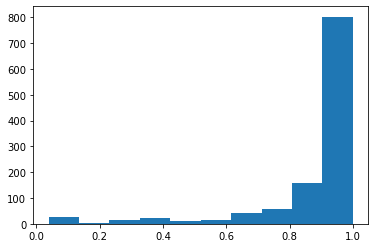

In [225]:
plt.hist(pct_present_list)

In [123]:
set(species_set[species_set['Load']=='Y'].index) - set(y1000_species['Species name'])

set()

In [ ]:
#Quantify information for SGD annotation

In [60]:
#For each of the 11 species

spec_source = 'Calb'
spec_target = 'Scer'

eggnog_path = 'eggnog_mapper' + os.sep + 'proteomics_set' + os.sep

eggnog_orths = pd.read_csv(base_dir + os.sep + eggnog_path + spec_source + '_' + spec_target + '_annot.csv')

#for both genomes

#Show how many map to something, how many map to S.cer

#EC percentage for each one

In [62]:
eggnog_orths

,Unnamed: 0,source_genename,target_genename,orth_type,#query,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,...,Gene.pathways.identifier,Gene.pathways.name,EC number,LoQAtE ID,PANTHER ID,PDB ID,PDB ID Chain,Pathway ID,UniParc ID,UniProtKB ID
0,0,sp|A0A1D8PQB9|ALS4_CANAL,NONE,no_eggnog_orthologs,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,sp|G1UB67|EED1_CANAL,NONE,no_eggnog_orthologs,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,sp|G1UBC2|PGA47_CANAL,NONE,no_eggnog_orthologs,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,sp|P0CT51|BLP1_CANAL,NONE,no_eggnog_orthologs,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,sp|P0CU38|ALS2_CANAL,NONE,no_eggnog_orthologs,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6776,6776,tr|A0A1D8PPS2|A0A1D8PPS2_CANAL,YOL011W,many2many,tr|A0A1D8PPS2|A0A1D8PPS2_CANAL,"KOG1325@1|root,KOG1325@2759|Eukaryota,38GBY@33...",4890|Ascomycota,G,lysophospholipase,PLB2,...,[],[],['3.1.1.5'],NaN,['PTHR10728:SF33'],NaN,NaN,NaN,['UPI0000131BC8'],['Q08108']
6777,6777,tr|A0A1D8PQR8|A0A1D8PQR8_CANAL,YDR541C,many2many,tr|A0A1D8PQR8|A0A1D8PQR8_CANAL,"COG0451@1|root,KOG1502@2759|Eukaryota,38GV9@33...",4890|Ascomycota,V,3-beta hydroxysteroid dehydrogenase/isomerase ...,-,...,[],[],NaN,NaN,['PTHR10366:SF564'],NaN,NaN,NaN,['UPI0001F7BD43'],['Q03049']
6778,6778,tr|A0A1D8PQR8|A0A1D8PQR8_CANAL,YGL039W,many2many,tr|A0A1D8PQR8|A0A1D8PQR8_CANAL,"COG0451@1|root,KOG1502@2759|Eukaryota,38GV9@33...",4890|Ascomycota,V,3-beta hydroxysteroid dehydrogenase/isomerase ...,-,...,[],[],NaN,['5794'],['PTHR10366:SF564'],NaN,NaN,NaN,['UPI000013B04D'],['P53183']
6779,6779,tr|A0A1D8PQR8|A0A1D8PQR8_CANAL,YGL157W,many2many,tr|A0A1D8PQR8|A0A1D8PQR8_CANAL,"COG0451@1|root,KOG1502@2759|Eukaryota,38GV9@33...",4890|Ascomycota,V,3-beta hydroxysteroid dehydrogenase/isomerase ...,-,...,[],[],NaN,['750'],['PTHR10366:SF564'],NaN,NaN,NaN,['UPI000013B107'],['P53111']


In [ ]:


C:\Users\heineib\Google Drive\Crick_LMS\projects\diverse_yeasts\eggnog_mapper\proteomics_set

In [ ]:
#Of all yeast proteins, which are most diverse and have the most 